In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.3.0


In [ ]:
train_df  = pd.read_csv('train.csv', engine='python', error_bad_lines=False).fillna(' ')
train_df.sample(10 , random_state = 1) 



Skipping line 67242: unexpected end of data


,comment_text,toxic
22270,He was not carrying any weapon... a weapon was...,0
46786,The Benayoun surname is of Algerian origin fro...,0
24038,"""\n\nNo political discussions, please\nPlease ...",0
21673,YOUR PRIVATE DETAILS PUBLICLY AVAILABLE SOON U...,1
49839,I know how frustrated you are right now. Stupi...,0
12920,"""\n\nVandalism\nPlease conduct your """"tests"""" ...",0
47363,"Hello Jeff, I don't know why you claim there w...",0
2536,"""Tmbox\n | type = style\n | image = \n | t...",0
47146,"""\nReplied on your talk page. (talk) """,0
66301,"June 2014 (UTC)\nRe: kt66, http://www.newkadam...",0


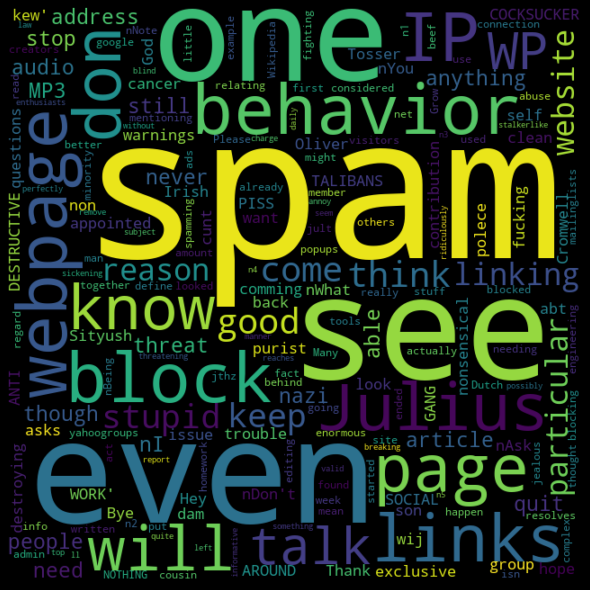

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
x=train_df['comment_text'].values
print(x)


["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."
 ...
 'I have time and again told you there is no Muslim perspective on these issues - there is a Secular perspective and a Hindu Fundamentalist perspective.If I were to include Muslim perspective - you would see for instance that the death toll in Gujarat riots would have been stated as 3,000 or even around 20000.'
 'I forgot to mention it before; due to the different nature

In [ ]:
y=train_df['toxic'].values

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
max_features = 20000
max_text_length = 400

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x)) 
x_tokenized  = x_tokenizer.texts_to_sequences(x)
x_train_val = sequence.pad_sequences(x_tokenized , maxlen = max_text_length)

In [44]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

embedding_dim  = 100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:] , dtype = 'float32')
    embeddings_index[word] = coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors. ')

Found 400000 word vectors. 


In [43]:
embedding_matrix = np.zeros((max_features , embedding_dim))
for word , index in x_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else: 
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [45]:
model = Sequential()
model.add(Embedding(max_features,
                   embedding_dim,
                   embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                   trainable=False))



model.add(Dropout(0.2))

In [46]:
filters =250
kernel_size = 3
hidden_dims = 250

In [47]:

model.add(Conv1D(filters,
                kernel_size,
                padding = 'valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                5,
                padding = 'valid',
                activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1 , activation ='sigmoid'))
model.summary()
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)              

In [50]:
x_train , x_val , y_train ,y_val = train_test_split(x_train_val ,y,
                                                 test_size = 0.15 ,random_state =1)

batch_size =32
epochs =3

model.fit(x_train,y_train,batch_size = batch_size,
          epochs =3,
          validation_data = (x_val ,y_val))

Epoch 1/3
1787/1787 [==============================] - 588s 329ms/step - loss: 0.1692 - accuracy: 0.9397 - val_loss: 0.1780 - val_accuracy: 0.9365
Epoch 2/3
1787/1787 [==============================] - 593s 332ms/step - loss: 0.1440 - accuracy: 0.9472 - val_loss: 0.1261 - val_accuracy: 0.9523
Epoch 3/3
1787/1787 [==============================] - 587s 329ms/step - loss: 0.1290 - accuracy: 0.9519 - val_loss: 0.1290 - val_accuracy: 0.9524


In [52]:
test_df = pd.read_csv('test.csv' , engine='python',error_bad_lines=False)

Skipping line 72882: unexpected end of data


In [53]:
x_test = test_df['comment_text'].values

In [54]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized , maxlen = max_text_length)

In [55]:
y_testing = model.predict(x_testing , verbose =1 ,batch_size =32)

2278/2278 [==============================] - 230s 101ms/step


In [56]:
y_testing.shape

(72879, 1)

In [57]:
y_testing[0]

array([0.98946047], dtype=float32)

In [58]:
test_df['Toxic']= ['not toxic' if x < .5 else 'toxic' for x in y_testing]
test_df[['comment_text','Toxic']].head(20) #sample 20

,comment_text,Toxic
0,Yo bitch Ja Rule is more succesful then you'll...,toxic
1,== From RfC == \n\n The title is fine as it is...,not toxic
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",not toxic
3,":If you have a look back at the source, the in...",not toxic
4,I don't anonymously edit articles at all.,not toxic
5,Thank you for understanding. I think very high...,not toxic
6,Please do not add nonsense to Wikipedia. Such ...,not toxic
7,:Dear god this site is horrible.,not toxic
8,""" \n Only a fool can believe in such numbers. ...",not toxic
9,== Double Redirects == \n\n When fixing double...,not toxic
